In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

from matplotlib import pyplot as plt
import pandas
import src
import gensim
import os
import os.path
import csv
import functools
import itertools
import collections
import scipy
import scipy.stats
from operator import itemgetter

INFO:gensim.corpora.sharded_corpus:Could not import Theano, will use standard float for default ShardedCorpus dtype.
2015-12-18 23:08:25 twoism gensim.corpora.sharded_corpus[2491] INFO Could not import Theano, will use standard float for default ShardedCorpus dtype.
INFO:summa.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English
2015-12-18 23:08:25 twoism summa.preprocessing.cleaner[2491] INFO 'pattern' package not found; tag filters are not available for English


In [3]:
model_config = {
    'num_topics': 500,
    'alpha': 1/500,
    'eta': 1/500,
    'decay': 0.5,
    'offset': 1.0,
    'iterations': 1000,
    'passes': 1,
    'max_bound_iterations': 1000, # special
    'algorithm': 'batch', # special
}

changeset_config = {
    'include_additions': True,
    'include_context': True,
    'include_message': False,
    'include_removals': True,
}

def get_config_string(config):
    return '-'.join([unicode(v) for k, v in sorted(config.items())])

alpha_bases = ['auto', 1, 2, 5]
eta_bases = ['auto', 1, 2, 5]
num_topics = [100, 200, 500]

def get_rank_name(kind, experiment, changeset_config, model_config):
    """
    kind = [changeset, release, temporal]
    experiment = [triage, feature_location]
    """
    cs_str = get_config_string(changeset_config)
    m_str = get_config_string(model_config)
    return '-'.join([kind, experiment, 'lda', cs_str, m_str, 'file', 'ranks']).lower() + '.csv.gz'

model_sweep = list()
for a, e, K in itertools.product(alpha_bases, eta_bases, num_topics):
    m = dict(model_config)
    if a != 'auto':
        a /= K
    if e != 'auto':
        e /= K
    m['alpha'] = a
    m['eta'] = e
    m['num_topics'] = K
    model_sweep.append(m)

corpus_sweep = list()
b = [True, False]
for a, c, m, r in itertools.product(b, repeat=4):
    conf = dict(changeset_config)
    conf['include_additions'] = a
    conf['include_context'] = c
    conf['include_message'] = m
    conf['include_removals'] = r
    if any(conf.values()):
        corpus_sweep.append(conf)

In [4]:
projects = list()
Project = collections.namedtuple('Project', 'name version data rankpath config')
for dirpath, dirname, filenames in os.walk("../data"):
    for filename in filenames:
        if filename == 'ref':
            _, _, name, version = dirpath.split('/')
            projects.append(Project(name, version, dirpath, '', dict()))
projects

[Project(name='tika', version='v1.8', data='../data/tika/v1.8', rankpath='', config={}),
 Project(name='pig', version='v0.14.0', data='../data/pig/v0.14.0', rankpath='', config={}),
 Project(name='bookkeeper', version='v4.3.0', data='../data/bookkeeper/v4.3.0', rankpath='', config={}),
 Project(name='openjpa', version='v2.3.0', data='../data/openjpa/v2.3.0', rankpath='', config={}),
 Project(name='mahout', version='v0.10.0', data='../data/mahout/v0.10.0', rankpath='', config={}),
 Project(name='zookeeper', version='v3.5.0', data='../data/zookeeper/v3.5.0', rankpath='', config={})]

In [5]:
cs_dit = list()
for project, rankstuff in itertools.product(projects, [
        (c, get_rank_name('changeset', 'triage', c, model_config)) for c in corpus_sweep]):
    config, rankname = rankstuff
    rankpath = os.path.join(project.data, rankname)
    if os.path.exists(rankpath):
        cs_dit.append(project._replace(rankpath=rankpath, config=config))

ms_dit = list()
for project, rankname in itertools.product(projects, [get_rank_name('changeset', 'triage', changeset_config, c) for c in model_sweep]):
    rankpath = os.path.join(project.data, rankname)
    if os.path.exists(rankpath):
        ms_dit.append(project._replace(rankpath=rankpath))
        
cs_flt = list()
for project, rankname in itertools.product(projects, [get_rank_name('changeset', 'feature_location', c, model_config) for c in corpus_sweep]):
    rankpath = os.path.join(project.data, rankname)
    if os.path.exists(rankpath):
        cs_flt.append(project._replace(rankpath=rankpath))

ms_flt = list()
for project, rankname in itertools.product(projects, [get_rank_name('changeset', 'feature_location', changeset_config, c) for c in model_sweep]):
    rankpath = os.path.join(project.data, rankname)
    if os.path.exists(rankpath):
        ms_flt.append(project._replace(rankpath=rankpath))



In [6]:
main_df = pandas.DataFrame(columns=["Subject", "Issue", "Rank", "Distance", "Additions", "Removals", "Context", "Message"])
for item in cs_dit:
    df = pandas.DataFrame(columns=main_df.columns)
    subdf = pandas.read_csv(item.rankpath)
    df["Rank"] = subdf.groupby("id")["rank"].min().values
    df["Distance"] = subdf.groupby("id")["distance"].min().values
    df["Issue"] = subdf.groupby("id")["rank"].min().index
    df["Subject"] = df.Subject.fillna(item.name.title().replace("keeper", "Keeper").replace("Openjpa", "OpenJPA") + " " + item.version)
    df["Additions"] = df.Additions.fillna(item.config['include_additions'])
    df["Removals"] = df.Removals.fillna(item.config['include_removals'])
    df["Context"] = df.Context.fillna(item.config['include_context'])
    df["Message"] = df.Message.fillna(item.config['include_message'])
    main_df = main_df.append(df, ignore_index=True)

OrderedDict([('BookKeeper v4.3.0', <matplotlib.axes._subplots.AxesSubplot object at 0x7faa50afecd0>), ('Mahout v0.10.0', <matplotlib.axes._subplots.AxesSubplot object at 0x7faa509bee10>), ('OpenJPA v2.3.0', <matplotlib.axes._subplots.AxesSubplot object at 0x7faa50951150>), ('Pig v0.14.0', <matplotlib.axes._subplots.AxesSubplot object at 0x7faa508c9fd0>), ('Tika v1.8', <matplotlib.axes._subplots.AxesSubplot object at 0x7faa50836750>), ('ZooKeeper v3.5.0', <matplotlib.axes._subplots.AxesSubplot object at 0x7faa507bc8d0>)])

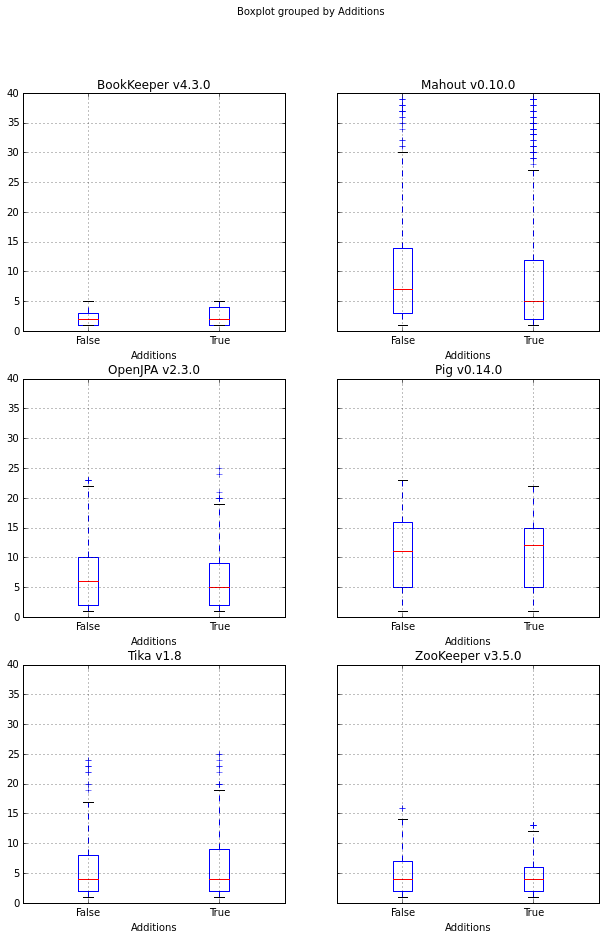

In [7]:
main_df.groupby("Subject").boxplot(column="Rank", by="Additions", figsize=(10, 15))

In [8]:
main_df.groupby(["Subject", "Additions"]).Rank.apply(src.utils.calculate_mrr)

Subject            Additions
BookKeeper v4.3.0  False        0.617247
                   True         0.622891
Mahout v0.10.0     False        0.280230
                   True         0.311753
OpenJPA v2.3.0     False        0.315077
                   True         0.344113
Pig v0.14.0        False        0.200080
                   True         0.176639
Tika v1.8          False        0.355327
                   True         0.414457
ZooKeeper v3.5.0   False        0.357364
                   True         0.365314
Name: Rank, dtype: float64

In [11]:
res = pandas.DataFrame(columns=["Subject", "Config", "NotIncl", "Incl", "p"])
for k in ["Additions", "Removals", "Context", "Message"]:
    for key, group in main_df.groupby(["Subject"]):
        sub = group.groupby(k).groups
        f = main_df.ix[sub[False]].Rank
        t = main_df.ix[sub[True]].Rank
        stat, p = scipy.stats.mannwhitneyu(f, t)
        res = res.append(
            dict(
                zip(res.columns, 
                    [key, k, src.utils.calculate_mrr(f), src.utils.calculate_mrr(t), p]))
            , ignore_index=True)
    sub = main_df.groupby(k).groups
    f = main_df.ix[sub[False]].Rank
    t = main_df.ix[sub[True]].Rank
    stat, p = scipy.stats.mannwhitneyu(f, t)
    res = res.append(
        dict(
            zip(res.columns, 
                ["**Overall**", k, src.utils.calculate_mrr(f), src.utils.calculate_mrr(t), p]))
        , ignore_index=True)
        

In [12]:
res[(res.NotIncl > res.Incl) & (res.p < 0.05)]

,Subject,Config,NotIncl,Incl,p
8,Mahout v0.10.0,Removals,0.310240,0.285494,3.012957e-04
10,Pig v0.14.0,Removals,0.212382,0.165875,7.141461e-13
12,ZooKeeper v3.5.0,Removals,0.381525,0.344173,1.853858e-11
13,**Overall**,Removals,0.365892,0.343557,2.612734e-14
22,Mahout v0.10.0,Message,0.307949,0.287499,3.774864e-02


In [13]:
res[(res.NotIncl < res.Incl) & (res.p < 0.05)]

,Subject,Config,NotIncl,Incl,p
1,Mahout v0.10.0,Additions,0.280230,0.311753,6.962983e-04
2,OpenJPA v2.3.0,Additions,0.315077,0.344113,1.438463e-03
5,ZooKeeper v3.5.0,Additions,0.357364,0.365314,3.700157e-04
6,**Overall**,Additions,0.349374,0.358010,2.262080e-04
14,BookKeeper v4.3.0,Context,0.569570,0.664609,1.534740e-11
17,Pig v0.14.0,Context,0.172989,0.200344,9.659076e-33
19,ZooKeeper v3.5.0,Context,0.349857,0.371883,9.960133e-07
20,**Overall**,Context,0.340298,0.365951,5.165138e-10
21,BookKeeper v4.3.0,Message,0.597125,0.640498,5.382724e-03
24,Pig v0.14.0,Message,0.176172,0.197559,9.908125e-03


In [14]:
len(main_df.ix[sub[False]].Rank), len(main_df.ix[sub[True]].Rank)

(7385, 8440)

In [15]:
for key, group in main_df.groupby(["Subject"]):
    ranks = dict()
    for subkey, subgroup in group.groupby(["Additions", "Removals", "Context", "Message"]):
        ranks[subkey] = subgroup.Rank

    print(key, scipy.stats.mstats.kruskalwallis(*ranks.values()))
    for x, y in itertools.combinations(main_df.groupby(["Additions", "Removals", "Context", "Message"]).groups.keys(), r=2):
        stat, p = scipy.stats.wilcoxon(ranks[x], ranks[y])
        if p < 0.01:
            print(x, y, p, "******")
        else:
            print(x, y, p)
    print()

BookKeeper v4.3.0 (100.13795809952776, 4.4622969985988723e-15)
(True, False, True, True) (True, True, False, True) 0.00948094768239 ******
(True, False, True, True) (False, True, False, True) 0.0546324628204
(True, False, True, True) (True, True, True, False) 0.000690377537119 ******
(True, False, True, True) (True, False, True, False) 0.00844649235618 ******
(True, False, True, True) (False, True, True, True) 0.0895844008762
(True, False, True, True) (False, False, True, True) 0.299801402527
(True, False, True, True) (True, True, True, True) 3.76534149136e-06 ******
(True, False, True, True) (False, False, True, False) 0.00365825474391 ******
(True, False, True, True) (True, False, False, True) 0.0108529046923
(True, False, True, True) (False, True, True, False) 0.000176434456611 ******
(True, False, True, True) (False, True, False, False) 0.0627442166216
(True, False, True, True) (True, True, False, False) 5.6527130921e-11 ******
(True, False, True, True) (True, False, False, False) 

In [16]:
len(list(itertools.combinations(main_df.groupby(["Additions", "Removals", "Context", "Message"]).groups.keys(), r=2)))

105

In [17]:
ranks = dict()
for subkey, subgroup in main_df.groupby(["Additions", "Removals", "Context", "Message"]):
    ranks[subkey] = subgroup.Rank

print('all', scipy.stats.mstats.kruskalwallis(*ranks.values()))
for x, y in itertools.combinations(main_df.groupby(["Additions", "Removals", "Context", "Message"]).groups.keys(), r=2):
    stat, p = scipy.stats.wilcoxon(ranks[x], ranks[y])
    if p < 0.01:
        print(x, y, p, "******")
    else:
        print(x, y, p)
print()

all (198.48154275712957, 1.1217088820570699e-34)
(True, False, True, True) (True, True, False, True) 0.490503136162
(True, False, True, True) (False, True, False, True) 1.07282120444e-18 ******
(True, False, True, True) (True, True, True, False) 0.01605135062
(True, False, True, True) (True, False, True, False) 0.0032156257024 ******
(True, False, True, True) (False, True, True, True) 9.04081175455e-08 ******
(True, False, True, True) (False, False, True, True) 6.31649543496e-09 ******
(True, False, True, True) (True, True, True, True) 4.95536831323e-06 ******
(True, False, True, True) (False, False, True, False) 2.76694397707e-14 ******
(True, False, True, True) (True, False, False, True) 0.00377184882604 ******
(True, False, True, True) (False, True, True, False) 8.17962954622e-11 ******
(True, False, True, True) (False, True, False, False) 1.77695204403e-37 ******
(True, False, True, True) (True, True, False, False) 0.000945229960451 ******
(True, False, True, True) (True, False, Fa